In [12]:
import sys
from pathlib import Path
import pandas as pd
import logging

logging.basicConfig(
    level=logging.INFO, 
    format="%(asctime)s - %(levelname)s - %(message)s"
)

import importlib
import data.cuped

importlib.reload(data.cuped)

# Add parent directory to sys.path
sys.path.append(str(Path().resolve()))

from data.extract import initialize_bigquery_client, extract_data
from data.bigquery_queries import get_marketing_data, get_dps_data
from data.transform import apply_cleanup
from data.cuped import apply_cuped_adjustment
from data.store import store_data_cloud
from utils.dates import get_iso_week_mondays
from utils.summary_stats import summarize_columns

import utils

importlib.reload(utils.summary_stats)


from utils.summary_stats import summarize_columns


In [15]:
entities = (
        'FP_PK','PY_DO'
    )

weeks = ['2025-02-08']
    
project = "logistics-customer-staging"

# # Initialize client
# client = initialize_bigquery_client(project)

# # Generate SQL
mkt_query = get_marketing_data(entities, weeks[0], restaurant_flag='IN')
dps_query = get_dps_data(entities, weeks[0], restaurant_flag='IN')

# # Extract data
df_raw = extract_data(client, mkt_query, dps_query)
print(df_raw.head())

df_raw["as_of_date"] = weeks[0]  

# # Transform data
df_cleaned = apply_cleanup(df_raw)
print(df_cleaned.head())

# # Apply CUPED
# df_cuped = apply_cuped_adjustment(
#     df_cleaned, 
#     pre_post_metric_pairs=[("orders_pre", "orders_post"), 
#                            ("analytical_profit_pre", "analytical_profit_post")]
# )
# print(df_cuped.head())

# # Store (locally only for testing)
# store_data_cloud(df_cuped, weeks, save_local=True, save_cloud_storage=False)


2025-05-14 21:13:13,389 - INFO - Starting data extraction...
2025-05-14 21:15:06,778 - INFO - Data extraction completed in 113.39 seconds.


  brand_name entity_id customer_id  is_customer_holdout  orders_pre  \
0    Pandora     FP_PK    pk5mb3nh                False          47   
1    Pandora     FP_PK    pkw6bqf0                False          53   
2    Pandora     FP_PK    pkabta16                False          21   
3    Pandora     FP_PK    pk98d24q                False          33   
4    Pandora     FP_PK    t9tvl5vd                False          27   

   orders_post  analytical_profit_pre  analytical_profit_post  
0           27              28.202469               17.987374  
1           28              14.348259               12.112171  
2            6              17.580291                6.683795  
3           17               7.918338                6.170878  
4           14              16.837372                6.873295  


2025-05-14 21:15:12,485 - INFO - apply_cleanup(): 0 rows removed. Final dataset size: 31554036


  brand_name entity_id customer_id  is_customer_holdout  orders_pre  \
0    Pandora     FP_PK    pk5mb3nh                False          47   
1    Pandora     FP_PK    pkw6bqf0                False          53   
2    Pandora     FP_PK    pkabta16                False          21   
3    Pandora     FP_PK    pk98d24q                False          33   
4    Pandora     FP_PK    t9tvl5vd                False          27   

   orders_post  analytical_profit_pre  analytical_profit_post  as_of_date  
0           27              28.202469               17.987374  2025-02-08  
1           28              14.348259               12.112171  2025-02-08  
2            6              17.580291                6.683795  2025-02-08  
3           17               7.918338                6.170878  2025-02-08  
4           14              16.837372                6.873295  2025-02-08  


In [25]:
summarize_columns(df_cleaned, columns=['orders_post', 'analytical_profit_post'], groupby=['entity_id', 'is_customer_holdout'])

,entity_id,is_customer_holdout,column,mean,std,min,max,missing_pct
0,AP_PA,False,orders_post,3.179680,3.687803,1.000000,160.000000,0.0
1,AP_PA,False,analytical_profit_post,4.988012,11.105949,-290.900351,507.243373,0.0
2,AP_PA,True,orders_post,3.086420,3.635444,1.000000,53.000000,0.0
3,AP_PA,True,analytical_profit_post,4.989429,11.162526,-82.548479,227.463396,0.0
4,DJ_CZ,False,orders_post,2.779686,3.303329,1.000000,110.000000,0.0
...,...,...,...,...,...,...,...,...
211,TB_QA,True,analytical_profit_post,6.787450,20.253671,-300.058354,328.749164,0.0
212,YS_TR,False,orders_post,2.798486,3.243357,1.000000,147.000000,0.0
213,YS_TR,False,analytical_profit_post,1.743059,6.652252,-319.292897,483.309145,0.0
214,YS_TR,True,orders_post,2.775602,3.132898,1.000000,58.000000,0.0


In [3]:
from utils.dates import get_iso_week_mondays
from datetime import date

get_iso_week_mondays(2025, 
                     date(2025, 2, 2), 
                     date(2025, 2, 3))

[datetime.date(2025, 2, 3)]

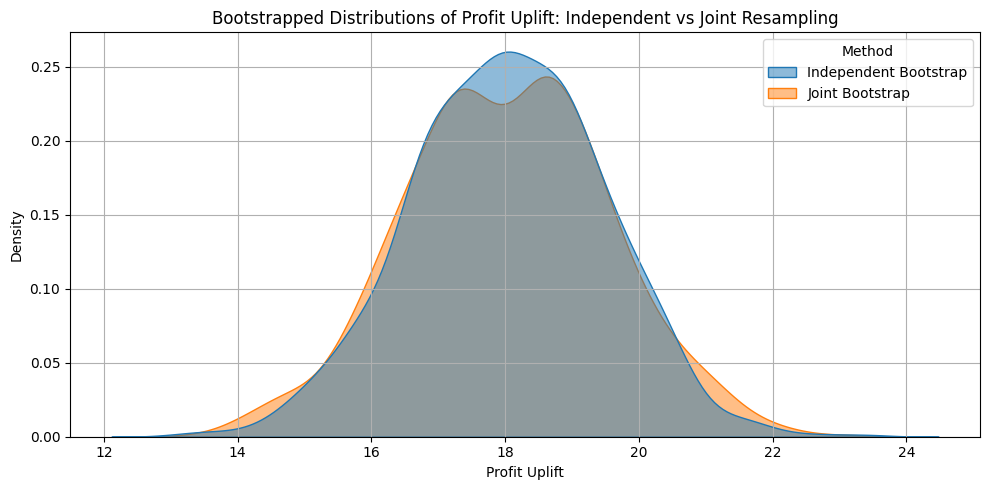

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set seed for reproducibility
np.random.seed(42)

# Simulate user-level CUPED-adjusted data
n_non_holdout = 500
n_holdout = 300

# Simulate profit and orders per user for both groups
non_holdout = pd.DataFrame({
    "profit": np.random.normal(loc=120, scale=20, size=n_non_holdout),
    "orders": np.random.normal(loc=60, scale=10, size=n_non_holdout),
    "is_customer_holdout": False
})

holdout = pd.DataFrame({
    "profit": np.random.normal(loc=100, scale=20, size=n_holdout),
    "orders": np.random.normal(loc=55, scale=10, size=n_holdout),
    "is_customer_holdout": True
})

# Combine into one dataset
df = pd.concat([non_holdout, holdout]).reset_index(drop=True)

# Number of bootstraps
n_resamples = 1000

# ----- Method 1: Independent Bootstraps -----
profit_uplift_independent = []

for i in range(n_resamples):
    non = non_holdout.sample(n=len(non_holdout), replace=True)
    hold = holdout.sample(n=len(holdout), replace=True)

    uplift = non['profit'].mean() - hold['profit'].mean()
    profit_uplift_independent.append(uplift)

# ----- Method 2: Joint Bootstrap -----
profit_uplift_joint = []

for i in range(n_resamples):
    sample_df = df.sample(n=len(df), replace=True)
    non = sample_df[sample_df["is_customer_holdout"] == False]
    hold = sample_df[sample_df["is_customer_holdout"] == True]

    if len(non) == 0 or len(hold) == 0:
        continue

    uplift = non['profit'].mean() - hold['profit'].mean()
    profit_uplift_joint.append(uplift)

# ----- Plotting -----
df_plot = pd.DataFrame({
    "Independent Bootstrap": profit_uplift_independent,
    "Joint Bootstrap": profit_uplift_joint
}).melt(var_name="Method", value_name="Profit Uplift")

plt.figure(figsize=(10, 5))
sns.kdeplot(data=df_plot, x="Profit Uplift", hue="Method", fill=True, common_norm=False, alpha=0.5)
plt.title("Bootstrapped Distributions of Profit Uplift: Independent vs Joint Resampling")
plt.xlabel("Profit Uplift")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
from pipelines.run_pipeline import main

run()

ModuleNotFoundError: No module named 'pricing_performance_holdouts'

In [22]:
from data.extract_stored_data import load_local_weekly_parquet_files

df = load_local_weekly_parquet_files(
    '2025-05-12',
    "outputs/raw_data/restaurants"
)

In [23]:
df.head()

,brand_name,entity_id,customer_id,is_customer_holdout,orders_pre,orders_post,analytical_profit_pre,analytical_profit_post,as_of_date,orders_post_cuped,analytical_profit_post_cuped
0,PEYA,PY_CR,37868290,True,0,1,0.000000,2.633086,2025-05-12,1.000000,2.633086
1,PEYA,PY_CR,31621951,True,0,2,0.000000,0.789993,2025-05-12,2.000000,0.789993
2,PEYA,PY_CR,75487937,True,2,2,0.292675,-5.305263,2025-05-12,5.018438,4.331026
3,PEYA,PY_CR,39011760,True,0,2,0.000000,-2.779899,2025-05-12,2.000000,-2.779899
4,PEYA,PY_CR,83017157,True,4,7,4.863332,5.462894,2025-05-12,6.953264,6.726388


In [3]:
#test = df[df['entity_id'] == 'PO_FI']

In [4]:
#test[test['is_customer_holdout'] == True]['customer_id'].nunique()

6129

In [25]:
from analysis.bootstrap import apply_bootstrap_diff_means

df, boot_dic = apply_bootstrap_diff_means(
    df,
    "brand_name",
    ["orders_post_cuped", "analytical_profit_post_cuped"]
)

brand_name groups:   0%|          | 0/6 [00:00<?, ?it/s]

Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
boot_dic

{('PO_FI',
  Timestamp('2025-05-12 00:00:00')): {'orders_post_cuped': {'observed_diff': np.float64(0.06605487228773166),
   'bootstrap_mean': np.float64(0.06830646507625496),
   'mean_non_holdout': np.float64(3.9635911751103783),
   'mean_holdout': np.float64(3.8975363028226466),
   'ci': (np.float64(-0.04787351911694573), np.float64(0.18344701693977108)),
   'pct_diff': np.float64(0.016947852991104625),
   'pct_ci': (np.float64(-0.012283020707793049),
    np.float64(0.047067429957462194)),
   'total_non_holdout': np.float64(1191293.0000000002),
   'total_holdout': np.float64(23888.0),
   'n_users_non_holdout': 300559,
   'n_users_holdout': 6129,
   'boot_diffs': array([ 9.09703889e-02,  4.67063457e-02,  6.98251095e-02,  5.33846163e-02,
          -8.40605035e-02, -5.28817694e-02, -2.61695994e-02,  7.20559000e-03,
           1.03405338e-01,  9.90807724e-02,  8.75357749e-02,  1.27091220e-01,
          -9.07918679e-02, -9.24511557e-03,  4.08907059e-03,  7.19215670e-02,
           8.056233

In [28]:
df

,brand_name,as_of_date,orders_post_cuped_observed_diff,orders_post_cuped_ci_low,orders_post_cuped_ci_high,orders_post_cuped_abs_lift,orders_post_cuped_abs_ci_low,orders_post_cuped_abs_ci_high,orders_post_cuped_pct_diff,orders_post_cuped_pct_ci_low,...,analytical_profit_post_cuped_abs_ci_high,analytical_profit_post_cuped_pct_diff,analytical_profit_post_cuped_pct_ci_low,analytical_profit_post_cuped_pct_ci_high,analytical_profit_post_cuped_total_non_holdout,analytical_profit_post_cuped_total_holdout,analytical_profit_post_cuped_mean_non_holdout,analytical_profit_post_cuped_mean_holdout,analytical_profit_post_cuped_n_users_non_holdout,analytical_profit_post_cuped_n_users_holdout
0,PEYA,2025-05-12,0.086515,0.056479,0.117381,1.029101e+06,6.718222e+05,1.396256e+06,0.013098,0.008551,...,4.440908e+06,0.029828,0.023082,0.037203,1.237318e+08,2.433084e+06,10.334661,10.035322,11895079,240862
1,Pandora,2025-05-12,-0.044774,-0.068782,-0.019510,-1.325676e+06,-2.036519e+06,-5.776565e+05,-0.006010,-0.009233,...,1.217272e+07,0.060822,0.053316,0.068250,1.892028e+08,3.626975e+06,6.390172,6.023795,29608395,602108
2,GR/CY,2025-05-12,0.302638,0.215788,0.387192,4.690075e+05,3.344136e+05,6.000438e+05,0.042397,0.030230,...,9.022508e+05,0.049335,0.018790,0.080064,1.201557e+07,2.303290e+05,7.630383,7.271634,1549733,31170
3,Talabat,2025-05-12,0.188384,0.128112,0.246623,1.818826e+06,1.236907e+06,2.381122e+06,0.015619,0.010622,...,8.597268e+06,0.029712,0.021699,0.037402,2.427310e+08,4.787664e+06,24.515223,23.807851,9654890,196119
4,HungerStation,2025-05-12,0.016593,-0.005238,0.039548,9.565536e+04,-3.019286e+04,2.279814e+05,0.004822,-0.001522,...,8.241687e+05,0.013131,0.001749,0.024800,3.366858e+07,6.707759e+05,5.840505,5.764810,5764669,116357
5,Glovo,2025-05-12,0.005208,-0.046902,0.053973,1.909311e+04,-1.719517e+05,1.978760e+05,0.001017,-0.009161,...,2.111523e+06,0.071679,0.054002,0.090451,2.511469e+07,4.770233e+05,6.823855,6.367442,3666205,74630


In [27]:
df[['orders_post_cuped_pct_diff','orders_post_cuped_pct_ci_low','orders_post_cuped_pct_ci_high','analytical_profit_post_cuped_pct_diff','analytical_profit_post_cuped_pct_ci_low','analytical_profit_post_cuped_pct_ci_high']] * 100

,brand_name,orders_post_cuped_pct_diff,orders_post_cuped_pct_ci_low,orders_post_cuped_pct_ci_high,analytical_profit_post_cuped_pct_diff,analytical_profit_post_cuped_pct_ci_low,analytical_profit_post_cuped_pct_ci_high
0,PEYAPEYAPEYAPEYAPEYAPEYAPEYAPEYAPEYAPEYAPEYAPE...,1.309804,0.855072,1.777106,2.982849,2.308193,3.720259
1,PandoraPandoraPandoraPandoraPandoraPandoraPand...,-0.600992,-0.923252,-0.261879,6.082164,5.331605,6.824999
2,GR/CYGR/CYGR/CYGR/CYGR/CYGR/CYGR/CYGR/CYGR/CYG...,4.239681,3.022995,5.424208,4.933536,1.879005,8.006420
3,TalabatTalabatTalabatTalabatTalabatTalabatTala...,1.561921,1.062197,2.044794,2.971174,2.169872,3.740184
4,HungerStationHungerStationHungerStationHungerS...,0.482177,-0.152195,1.149202,1.313067,0.174890,2.480029
5,GlovoGlovoGlovoGlovoGlovoGlovoGlovoGlovoGlovoG...,0.101727,-0.916147,1.054269,7.167920,5.400176,9.045115


In [8]:
import numpy as np

def compute_profitable_growth(
    profit_result: dict,
    order_result: dict,
    alpha: float = 0.05
) -> dict:
    
    """
    Compute profitable growth and confidence interval from bootstrapped profit and order results,
    and return the observed profitable growth from the observed differences.

    Profitable growth is defined as:
        ((Δ profit / profit per order) + Δ orders) / (baseline holdout orders scaled by user ratio)

    Args:
        profit_result (dict): Output from bootstrap_diff_means_parallel for profit.
        order_result (dict): Output from bootstrap_diff_means_parallel for orders.
        alpha (float): Significance level for CI (default 0.05 for 95% CI).

    Returns:
        dict: Profitable growth point estimate (mean of bootstraps), confidence interval, 
              observed profitable growth (from raw diff), and full bootstrap distribution.
    """
    
    boot_profit = np.array(profit_result["boot_diffs"])
    boot_order = np.array(order_result["boot_diffs"])

    total_profit = profit_result["total_non_holdout"]
    total_orders = order_result["total_non_holdout"]
    profit_per_order = total_profit / total_orders if total_orders != 0 else np.nan

    n_users_non_holdout = profit_result["n_users_non_holdout"]
    n_users_holdout = profit_result["n_users_holdout"]
    user_ratio = n_users_non_holdout / n_users_holdout
    baseline_orders = order_result["mean_holdout"] * (user_ratio * n_users_holdout)

    # Bootstrap distribution
    result = []
    B = len(boot_profit)
    for i in range(B):
        delta_profit = boot_profit[i]
        delta_order = boot_order[i]
        growth = (
            ((delta_profit * n_users_non_holdout) / profit_per_order) +
            (delta_order * n_users_non_holdout)
        ) / baseline_orders
        result.append(growth)

    result = np.array(result)
    ci = np.nanpercentile(result, [100 * alpha / 2, 100 * (1 - alpha / 2)])
    mean_val = np.nanmean(result)

    # Observed difference values
    observed_delta_profit = profit_result["observed_diff"]
    observed_delta_order = order_result["observed_diff"]

    observed_growth = (
        ((observed_delta_profit * n_users_non_holdout) / profit_per_order) +
        (observed_delta_order * n_users_non_holdout)
    ) / baseline_orders

    return {
        "profitable_growth": round(mean_val, 4),
        "observed_profitable_growth": round(observed_growth, 4),
        "ci": (round(ci[0], 4), round(ci[1], 4)),
        "distribution": result
    }


In [9]:
import pandas as pd

growth_rows = []

for (entity, week), metrics_dict in boot_dic.items():
    if "orders_post_cuped" not in metrics_dict or "analytical_profit_post_cuped" not in metrics_dict:
        continue  # skip if required keys missing

    order_result = metrics_dict["orders_post_cuped"]
    profit_result = metrics_dict["analytical_profit_post_cuped"]

    growth_summary = compute_profitable_growth(
        profit_result=profit_result,
        order_result=order_result
    )

    growth_rows.append({
        "entity": entity,
        "week": week,
        "profitable_growth": growth_summary["profitable_growth"],
        "observed_profitable_growth": growth_summary["observed_profitable_growth"],
        "ci_low": growth_summary["ci"][0],
        "ci_high": growth_summary["ci"][1]
    })

df_growth = pd.DataFrame(growth_rows)


In [10]:
df_growth

,entity,week,profitable_growth,observed_profitable_growth,ci_low,ci_high
0,PO_FI,2025-05-12,-1.6511,-1.6489,-2.7713,-0.549


In [16]:
((-1.6489 - -1.6511) / -1.6511) * 100

-0.1332445036642226

In [29]:
from analysis.profitable_growth import apply_profitable_growth

tt = apply_profitable_growth(
    boot_dic,
    "brand_name")

In [30]:
tt[['profitable_growth','observed_profitable_growth','ci_low','ci_high']] = tt[['profitable_growth','observed_profitable_growth','ci_low','ci_high']] * 100

tt

,brand_name,week,profitable_growth,observed_profitable_growth,ci_low,ci_high
0,PEYA,2025-05-12,4.24,4.24,3.21,5.32
1,Pandora,2025-05-12,5.10,5.10,4.25,6.01
2,GR/CY,2025-05-12,9.15,9.14,5.46,12.98
3,Talabat,2025-05-12,4.51,4.49,3.29,5.61
4,HungerStation,2025-05-12,1.83,1.78,0.21,3.36
5,Glovo,2025-05-12,6.80,6.80,4.56,9.11


In [12]:
df

,entity_id,as_of_date,orders_post_cuped_observed_diff,orders_post_cuped_ci_low,orders_post_cuped_ci_high,orders_post_cuped_abs_lift,orders_post_cuped_abs_ci_low,orders_post_cuped_abs_ci_high,orders_post_cuped_pct_diff,orders_post_cuped_pct_ci_low,...,analytical_profit_post_cuped_abs_ci_high,analytical_profit_post_cuped_pct_diff,analytical_profit_post_cuped_pct_ci_low,analytical_profit_post_cuped_pct_ci_high,analytical_profit_post_cuped_total_non_holdout,analytical_profit_post_cuped_total_holdout,analytical_profit_post_cuped_mean_non_holdout,analytical_profit_post_cuped_mean_holdout,analytical_profit_post_cuped_n_users_non_holdout,analytical_profit_post_cuped_n_users_holdout
0,PY_CR,2025-05-12,0.165572,-0.018280,0.346760,2.959675e+04,-3.267601e+03,61985.157807,0.035588,-0.003929,...,7.935910e+04,0.054124,-0.127635,0.229615,3.643238e+05,6.952764e+03,2.038118,1.933472,178755,3596
1,PY_VE,2025-05-12,0.095660,-0.117519,0.308383,1.119208e+04,-1.374957e+04,36080.541926,0.023004,-0.028260,...,3.552371e+04,-0.038902,-0.153735,0.079505,4.294292e+05,8.989764e+03,3.670367,3.818931,116999,2354
2,FP_KH,2025-05-12,-0.286166,-0.435714,-0.129574,-5.209001e+04,-7.931179e+04,-23586.051877,-0.059543,-0.090660,...,1.069251e+05,0.103746,0.059768,0.152911,7.718102e+05,1.465548e+04,4.240086,3.841541,182027,3815
3,FY_CY,2025-05-12,0.053107,-0.264897,0.360842,1.039307e+04,-5.184054e+04,70617.213513,0.005941,-0.029636,...,-1.492033e+05,-0.123243,-0.195279,-0.061088,2.141415e+06,4.960961e+04,10.942277,12.480405,195701,3975
4,PY_NI,2025-05-12,-0.033199,-0.263240,0.222443,-8.855906e+03,-7.022063e+04,59337.819237,-0.004456,-0.035330,...,1.701414e+05,0.029541,-0.016127,0.075527,2.319274e+06,4.512122e+04,8.694396,8.444923,266755,5343
5,FP_LA,2025-05-12,-0.318559,-0.813403,0.161235,-3.549388e+04,-9.062935e+04,17964.804580,-0.033450,-0.085412,...,6.696866e+04,0.036032,-0.034046,0.106842,6.493856e+05,1.302882e+04,5.828268,5.625568,111420,2316
6,AP_PA,2025-05-12,0.268047,0.100863,0.436032,1.313996e+05,4.944405e+04,213747.506070,0.035374,0.013311,...,1.657841e+05,-0.011575,-0.049127,0.027949,5.863080e+06,1.211853e+05,11.960318,12.100380,490211,10015
7,DJ_CZ,2025-05-12,0.020568,-0.083833,0.126875,1.520169e+04,-6.195935e+04,93770.136114,0.003634,-0.014810,...,3.225975e+05,0.028414,-0.022007,0.082891,4.002410e+06,7.977682e+04,5.415417,5.265797,739077,15150
8,EF_GR,2025-05-12,0.340906,0.246896,0.426112,4.701094e+05,3.404694e+05,587608.858093,0.049551,0.035887,...,1.188107e+06,0.097516,0.063367,0.132059,9.874157e+06,1.807194e+05,7.160375,6.524166,1379000,27700
9,FO_NO,2025-05-12,-0.055853,-0.177368,0.047068,-2.652370e+04,-8.422999e+04,22352.231456,-0.013653,-0.043359,...,3.266141e+05,0.013855,-0.055711,0.069569,4.759861e+06,9.436328e+04,10.023124,9.886148,474888,9545


In [12]:
boot_dic

{('PO_FI',
  Timestamp('2025-05-12 00:00:00')): {'orders_post_cuped': {'observed_diff': np.float64(0.06605487228773166),
   'bootstrap_mean': np.float64(0.06830646507625496),
   'mean_non_holdout': np.float64(3.9635911751103783),
   'mean_holdout': np.float64(3.8975363028226466),
   'ci': (np.float64(-0.04787351911694573), np.float64(0.18344701693977108)),
   'pct_diff': np.float64(0.016947852991104625),
   'pct_ci': (np.float64(-0.012283020707793049),
    np.float64(0.047067429957462194)),
   'total_non_holdout': np.float64(1191293.0000000002),
   'total_holdout': np.float64(23888.0),
   'n_users_non_holdout': 300559,
   'n_users_holdout': 6129,
   'boot_diffs': array([ 9.09703889e-02,  4.67063457e-02,  6.98251095e-02,  5.33846163e-02,
          -8.40605035e-02, -5.28817694e-02, -2.61695994e-02,  7.20559000e-03,
           1.03405338e-01,  9.90807724e-02,  8.75357749e-02,  1.27091220e-01,
          -9.07918679e-02, -9.24511557e-03,  4.08907059e-03,  7.19215670e-02,
           8.056233

In [13]:
from data.extract_stored_data import load_local_weekly_parquet_files

df = load_local_weekly_parquet_files(
    '2025-05-12',
    "outputs/raw_data/quick_commerce"
)

In [21]:
print(df[df['entity_id'] == 'FY_CY']['analytical_profit_post'].mean())

print(df[df['entity_id'] == 'FY_CY']['analytical_profit_post_cuped'].mean())

4.382116569903618
4.382116569903619


In [13]:
from data.extract_stored_data import load_local_profitable_growth_files


df = load_local_profitable_growth_files(
    weeks=["2025-05-19"],
    vertical_type="restaurants",
    group="entity_id"
)

In [6]:
df.col

Index(['entity_id', 'as_of_date', 'orders_post_cuped_observed_diff',
       'orders_post_cuped_ci_low', 'orders_post_cuped_ci_high',
       'orders_post_cuped_abs_lift', 'orders_post_cuped_abs_ci_low',
       'orders_post_cuped_abs_ci_high', 'orders_post_cuped_pct_diff',
       'orders_post_cuped_pct_ci_low', 'orders_post_cuped_pct_ci_high',
       'orders_post_cuped_total_non_holdout',
       'orders_post_cuped_total_holdout', 'orders_post_cuped_mean_non_holdout',
       'orders_post_cuped_mean_holdout',
       'orders_post_cuped_n_users_non_holdout',
       'orders_post_cuped_n_users_holdout',
       'analytical_profit_post_cuped_observed_diff',
       'analytical_profit_post_cuped_ci_low',
       'analytical_profit_post_cuped_ci_high',
       'analytical_profit_post_cuped_abs_lift',
       'analytical_profit_post_cuped_abs_ci_low',
       'analytical_profit_post_cuped_abs_ci_high',
       'analytical_profit_post_cuped_pct_diff',
       'analytical_profit_post_cuped_pct_ci_low',
    

In [14]:
df[['observed_profitable_growth','ci_low','ci_high','orders_post_cuped_pct_diff','orders_post_cuped_pct_ci_low','orders_post_cuped_pct_ci_high','analytical_profit_post_cuped_pct_diff','analytical_profit_post_cuped_pct_ci_low','analytical_profit_post_cuped_pct_ci_high']] = df[['observed_profitable_growth','ci_low','ci_high','orders_post_cuped_pct_diff','orders_post_cuped_pct_ci_low','orders_post_cuped_pct_ci_high','analytical_profit_post_cuped_pct_diff','analytical_profit_post_cuped_pct_ci_low','analytical_profit_post_cuped_pct_ci_high']] * 100

df[['entity_id','observed_profitable_growth','ci_low','ci_high','orders_post_cuped_pct_diff','orders_post_cuped_pct_ci_low','orders_post_cuped_pct_ci_high','analytical_profit_post_cuped_pct_diff','analytical_profit_post_cuped_pct_ci_low','analytical_profit_post_cuped_pct_ci_high']]

,entity_id,observed_profitable_growth,ci_low,ci_high,orders_post_cuped_pct_diff,orders_post_cuped_pct_ci_low,orders_post_cuped_pct_ci_high,analytical_profit_post_cuped_pct_diff,analytical_profit_post_cuped_pct_ci_low,analytical_profit_post_cuped_pct_ci_high
0,FP_KH,2.94,-4.20,9.67,-5.771793,-9.220480,-2.519972,10.183608,5.410702,14.602940
1,PY_VE,-1.80,-18.53,14.72,2.343571,-2.867353,7.263245,-3.887489,-16.080419,7.570885
2,FY_CY,-13.73,-23.48,-3.80,0.405285,-3.064996,3.719215,-12.339039,-18.968552,-5.504077
3,PY_CR,9.85,-9.67,28.54,3.573222,-0.417294,7.372693,6.448151,-12.098565,25.022203
4,PY_NI,2.32,-4.90,9.33,-0.503960,-3.639105,2.602920,2.922050,-1.769449,7.284138
5,FP_LA,-0.31,-10.97,11.30,-3.742316,-9.091247,1.973811,3.701004,-2.916045,10.716455
6,AP_PA,2.37,-2.90,7.56,3.546132,1.514722,5.738309,-1.120637,-4.843032,2.367563
7,DJ_CZ,2.71,-2.93,7.81,0.392739,-1.516931,2.214950,2.359810,-2.479872,6.774200
8,EF_GR,14.83,11.00,18.60,4.932276,3.438682,6.318082,10.417417,7.231026,13.674578
9,FO_NO,-0.71,-8.37,6.53,-1.269291,-4.077669,1.453446,0.574559,-5.370272,6.529499


In [23]:
df = load_local_profitable_growth_files(
    weeks=["2025-05-19"],
    vertical_type="restaurants",
    group="brand_name"
)

In [24]:
df

,brand_name,as_of_date,orders_post_cuped_observed_diff,orders_post_cuped_ci_low,orders_post_cuped_ci_high,orders_post_cuped_abs_lift,orders_post_cuped_abs_ci_low,orders_post_cuped_abs_ci_high,orders_post_cuped_pct_diff,orders_post_cuped_pct_ci_low,...,analytical_profit_post_cuped_total_holdout,analytical_profit_post_cuped_mean_non_holdout,analytical_profit_post_cuped_mean_holdout,analytical_profit_post_cuped_n_users_non_holdout,analytical_profit_post_cuped_n_users_holdout,week,profitable_growth,observed_profitable_growth,ci_low,ci_high
0,Pandora,2025-05-19,-0.050520,-0.077330,-0.024812,-1.528389e+06,-2.339449e+06,-7.506261e+05,-0.006592,-0.010090,...,3.974010e+06,6.826836,6.459326,30252965,615236,2025-05-19,0.0468,0.0469,0.0376,0.0561
1,PEYA,2025-05-19,0.087172,0.056114,0.118851,1.040935e+06,6.700678e+05,1.419219e+06,0.013127,0.008450,...,2.452272e+06,10.376600,10.073579,11941126,241836,2025-05-19,0.0428,0.0427,0.0315,0.0537
2,GR/CY,2025-05-19,0.311357,0.220551,0.407322,4.911835e+05,3.479309e+05,6.425729e+05,0.042008,0.029756,...,2.409818e+05,7.878583,7.471610,1577556,31739,2025-05-19,0.0956,0.0958,0.0554,0.1329
3,Talabat,2025-05-19,0.183842,0.120152,0.245018,1.801164e+06,1.177169e+06,2.400527e+06,0.014797,0.009671,...,4.995236e+06,25.178862,24.447860,9797346,199193,2025-05-19,0.0445,0.0443,0.0322,0.0558
4,HungerStation,2025-05-19,0.015406,-0.007702,0.038720,9.486643e+04,-4.742850e+04,2.384318e+05,0.004268,-0.002134,...,7.530648e+05,6.135512,6.062836,6157889,124210,2025-05-19,0.0161,0.0162,-0.0000,0.0317
5,Glovo,2025-05-19,-0.005538,-0.056944,0.048060,-2.100250e+04,-2.159634e+05,1.822714e+05,-0.001045,-0.010741,...,5.177838e+05,7.166300,6.681254,3792559,77196,2025-05-19,0.0669,0.0666,0.0448,0.0914


In [25]:
df[['observed_profitable_growth','ci_low','ci_high','orders_post_cuped_pct_diff','orders_post_cuped_pct_ci_low','orders_post_cuped_pct_ci_high','analytical_profit_post_cuped_pct_diff','analytical_profit_post_cuped_pct_ci_low','analytical_profit_post_cuped_pct_ci_high']] = df[['observed_profitable_growth','ci_low','ci_high','orders_post_cuped_pct_diff','orders_post_cuped_pct_ci_low','orders_post_cuped_pct_ci_high','analytical_profit_post_cuped_pct_diff','analytical_profit_post_cuped_pct_ci_low','analytical_profit_post_cuped_pct_ci_high']] * 100

df[['brand_name','observed_profitable_growth','ci_low','ci_high','orders_post_cuped_pct_diff','orders_post_cuped_pct_ci_low','orders_post_cuped_pct_ci_high','analytical_profit_post_cuped_pct_diff','analytical_profit_post_cuped_pct_ci_low','analytical_profit_post_cuped_pct_ci_high']].round(2)

,brand_name,observed_profitable_growth,ci_low,ci_high,orders_post_cuped_pct_diff,orders_post_cuped_pct_ci_low,orders_post_cuped_pct_ci_high,analytical_profit_post_cuped_pct_diff,analytical_profit_post_cuped_pct_ci_low,analytical_profit_post_cuped_pct_ci_high
0,Pandora,4.69,3.76,5.61,-0.66,-1.01,-0.32,5.69,4.91,6.43
1,PEYA,4.27,3.15,5.37,1.31,0.85,1.79,3.01,2.29,3.77
2,GR/CY,9.58,5.54,13.29,4.20,2.98,5.50,5.45,2.16,8.50
3,Talabat,4.43,3.22,5.58,1.48,0.97,1.97,2.99,2.19,3.77
4,HungerStation,1.62,-0.00,3.17,0.43,-0.21,1.07,1.20,0.01,2.29
5,Glovo,6.66,4.48,9.14,-0.10,-1.07,0.91,7.26,5.42,9.14
